In [329]:
import pandas as pd
import numpy as np
from tcrdist.repertoire import TCRrep
from scipy.sparse import csr_matrix
import matplotlib.colors as mcolors

#### **数据读取**

In [6]:
data = pd.read_csv('vdjdb.txt', sep = '\t')

In [7]:
score = data[data['vdjdb.score'].isin([1, 2, 3])]

In [8]:
score[(score['gene'] == 'TRA') & (score['species'] == 'HomoSapiens')]

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,antigen.species,reference.id,method,meta,cdr3fix,vdjdb.score,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVPSGAGSYQLTF"", ""cdr3_old"": ""CAVPSG...",2,sort,sanger,no,no
5,3,TRA,CAVKASGSRLT,TRAV2*01,NaN,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAVKASGSRLT"", ""cdr3_old"": ""CAVKASGSR...",2,sort,sanger,yes,yes
7,4,TRA,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAYRPPGTYKYIF"", ""cdr3_old"": ""CAYRPPG...",2,sort,sanger,no,no
9,5,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEQGGL,...,HIV-1,PMID:15596521,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD8+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIVRAPGRADMRF"", ""cdr3_old"": ""CIVRAPG...",2,sort,sanger,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92681,30550,TRA,CIALNARLMF,TRAV26-1*01,TRAJ31*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,PQPELPYPQPQL,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CIALNARLMF"", ""cdr3_old"": ""CIALNARLMF...",2,sort,singlecell,no,no
92683,30551,TRA,CAMREGRYSSASKIIF,TRAV14/DV4*01,TRAJ3*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,FPQPEQPFPWQP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAMREGRYSSASKIIF"", ""cdr3_old"": ""CAMR...",2,sort,singlecell,no,no
92685,30552,TRA,CLVGDGDGGATNKLIF,TRAV4*01,TRAJ32*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,FPQPEQPFPWQP,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CLVGDGDGGATNKLIF"", ""cdr3_old"": ""CLVG...",2,sort,singlecell,no,no
92689,30554,TRA,CAASVLYGSSNTGKLIF,TRAV29/DV5*01,TRAJ37*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,QLQPFPQPELPY,...,Wheat,PMID:33927715,"{""frequency"": """", ""identification"": ""tetramer-...","{""cell.subset"": ""CD4+"", ""clone.id"": """", ""donor...","{""cdr3"": ""CAASVLYGSSNTGKLIF"", ""cdr3_old"": ""CAA...",2,sort,singlecell,no,no


#### **数据准备**

In [9]:
data = data.drop(['web.method', 'web.method.seq', 'web.cdr3fix.nc','web.cdr3fix.unmp','reference.id', 'method', 'meta', 'cdr3fix'], axis=1)
data = data.drop(['mhc.a', 'mhc.b', 'mhc.class', 'antigen.epitope', 'antigen.gene'], axis = 1)

In [10]:
data_clean = data.dropna()

#### **Alpha链**

In [11]:
data_alpha = data_clean[data_clean['gene'] == 'TRA']

##### **Distance(Human)**

In [12]:
# data_alpha_human = data_alpha[data_alpha['species'] == 'HomoSapiens']

In [13]:
# 抽样
# data_alpha_human_sampled = conditional_sample(data_alpha_human, percentage=0.3)

In [14]:
data_alpha_human_sampled = score[(score['gene'] == 'TRA') & (score['species'] == 'HomoSapiens')]

改名

In [15]:
data_alpha_human_sampled = data_alpha_human_sampled.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})

In [16]:
tr_human_alpha = TCRrep(cell_df = data_alpha_human_sampled, 
            organism = 'human', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000002272ED05940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:190: UserWarning: Not all cells/sequences could be grouped into clones.182 of 2911 were not 

In [17]:
tr_human_alpha.pw_alpha

array([[  0, 162, 163, ..., 182, 171, 157],
       [162,   0,  92, ..., 160, 156,  98],
       [163,  92,   0, ..., 160, 176,  63],
       ...,
       [182, 160, 160, ...,   0, 141, 133],
       [171, 156, 176, ..., 141,   0, 158],
       [157,  98,  63, ..., 133, 158,   0]], dtype=int16)

In [18]:
tr_human_alpha.pw_alpha.shape

(2725, 2725)

##### **Distance(Mouse)**

In [19]:
data_alpha_mouse = data_alpha[data_alpha['species'] == 'MusMusculus']

改名

In [20]:
data_alpha_mouse = data_alpha_mouse.rename(columns = {'gene':'gene_a',
                                           'cdr3':'cdr3_a_aa',
                                           'v.segm':'v_a_gene',
                                           'j.segm':'j_a_gene'})

In [21]:
tr = TCRrep(cell_df = data_alpha_mouse, 
            organism = 'mouse', 
            chains = ['alpha'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000002272ED05940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


In [22]:
tr.pw_alpha

array([[  0,  90,  90, ..., 115, 148, 133],
       [ 90,   0,  24, ..., 145, 133, 154],
       [ 90,  24,   0, ..., 145, 145, 154],
       ...,
       [115, 145, 145, ...,   0, 115, 116],
       [148, 133, 145, ..., 115,   0, 154],
       [133, 154, 154, ..., 116, 154,   0]], dtype=int16)

#### **Beta链**

In [23]:
data_beta = data_clean[data_clean['gene'] == 'TRB']

##### **Distance(Human)**

In [24]:
data_beta_human = data_beta[data_beta['species'] == 'HomoSapiens']

改名

In [26]:
data_beta_human_sampled = data_beta_human_sampled.rename(columns = {'gene':'gene_b',
                                           'cdr3':'cdr3_b_aa',
                                           'v.segm':'v_b_gene',
                                           'j.segm':'j_b_gene'})

In [27]:
tr_human_beta = TCRrep(cell_df = data_beta_human_sampled, 
            organism = 'human', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000002272ED05940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


In [28]:
tr_human_beta.pw_beta

array([[  0, 170, 159, ..., 151, 141, 140],
       [170,   0, 127, ..., 148, 174, 160],
       [159, 127,   0, ..., 140, 157, 153],
       ...,
       [151, 148, 140, ...,   0, 121,  97],
       [141, 174, 157, ..., 121,   0, 122],
       [140, 160, 153, ...,  97, 122,   0]], dtype=int16)

##### **Distance(Mouse)**

In [29]:
data_beta_mouse = data_beta[data_beta['species'] == 'MusMusculus']

In [30]:
data_beta_mouse = data_beta_mouse.rename(columns = {'gene':'gene_b',
                                           'cdr3':'cdr3_b_aa',
                                           'v.segm':'v_b_gene',
                                           'j.segm':'j_b_gene'})

In [31]:
data_beta_mouse.reset_index(drop=True, inplace=True)
data_beta_mouse.head()

,complex.id,gene_b,cdr3_b_aa,v_b_gene,j_b_gene,species,antigen.species,vdjdb.score
0,105,TRB,CASGGQGRAEQFF,TRBV13-2*01,TRBJ2-1*01,MusMusculus,GallusGallus,3
1,106,TRB,CTCSADRVGNTLYF,TRBV1*01,TRBJ1-3*01,MusMusculus,MusMusculus,3
2,108,TRB,CASGGGGTLYF,TRBV13-2*01,TRBJ2-4*01,MusMusculus,Synthetic,3
3,110,TRB,CTCSAAPDWGASAETLYF,TRBV1*01,TRBJ2-3*01,MusMusculus,MusMusculus,3
4,112,TRB,CASGGGGTLYF,TRBV13-2*01,TRBJ2-4*01,MusMusculus,MusMusculus,3


In [32]:
tr_mouse_beta = TCRrep(cell_df = data_beta_mouse, 
            organism = 'mouse', 
            chains = ['beta'], 
            db_file = 'alphabeta_gammadelta_db.tsv')

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\tcrdist\repertoire.py:833: FutureWarning: The provided callable <function sum at 0x000002272ED05940> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clones = cell_df.groupby(index_cols)['count'].agg(np.sum).reset_index()


In [33]:
tr_mouse_beta.pw_beta

array([[  0, 155, 152, ...,  98, 122, 134],
       [155,   0, 162, ..., 119, 175, 164],
       [152, 162,   0, ..., 167, 168, 164],
       ...,
       [ 98, 119, 167, ...,   0, 144, 105],
       [122, 175, 168, ..., 144,   0, 129],
       [134, 164, 164, ..., 105, 129,   0]], dtype=int16)

## Clustering


### Human

#### alpha

In [34]:
alpha_distance = tr_human_alpha.pw_alpha

In [35]:
clone_df = tr_human_alpha.clone_df

### 降维

先进性mds对数据进行降维，再把mds的结果作为tsne的初始化参数的输入

In [37]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [164]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, n_init=5)
positions = mds.fit_transform(alpha_distance)

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


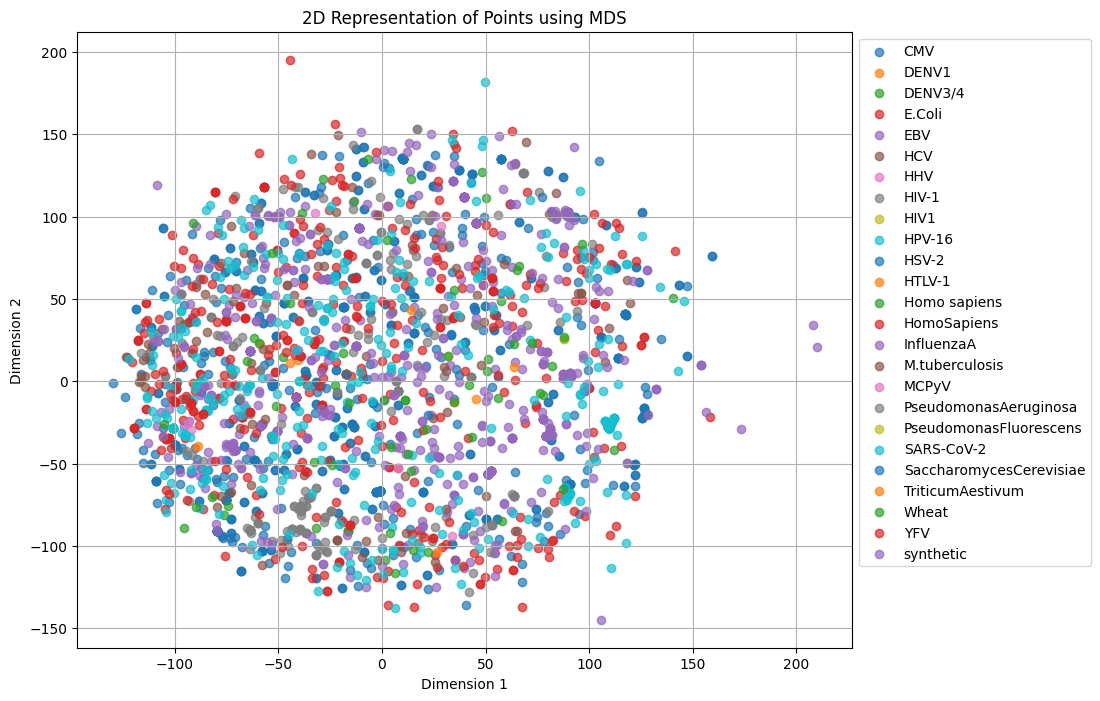

In [165]:

specificity = clone_df['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2"  # 根据 unique_antigen_species 的数量增减颜色
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indices = (specificity == antigen_species)
    plt.scatter(positions[true_indices, 0], positions[true_indices, 1], color=color, label=antigen_species, alpha=0.7)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Representation of Points using MDS')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True)
plt.show()

In [167]:
tsne_reducer = TSNE(n_components=2, random_state=42, metric='precomputed', init=positions, perplexity=100, learning_rate=1000)
tsne_results = tsne_reducer.fit_transform(alpha_distance)

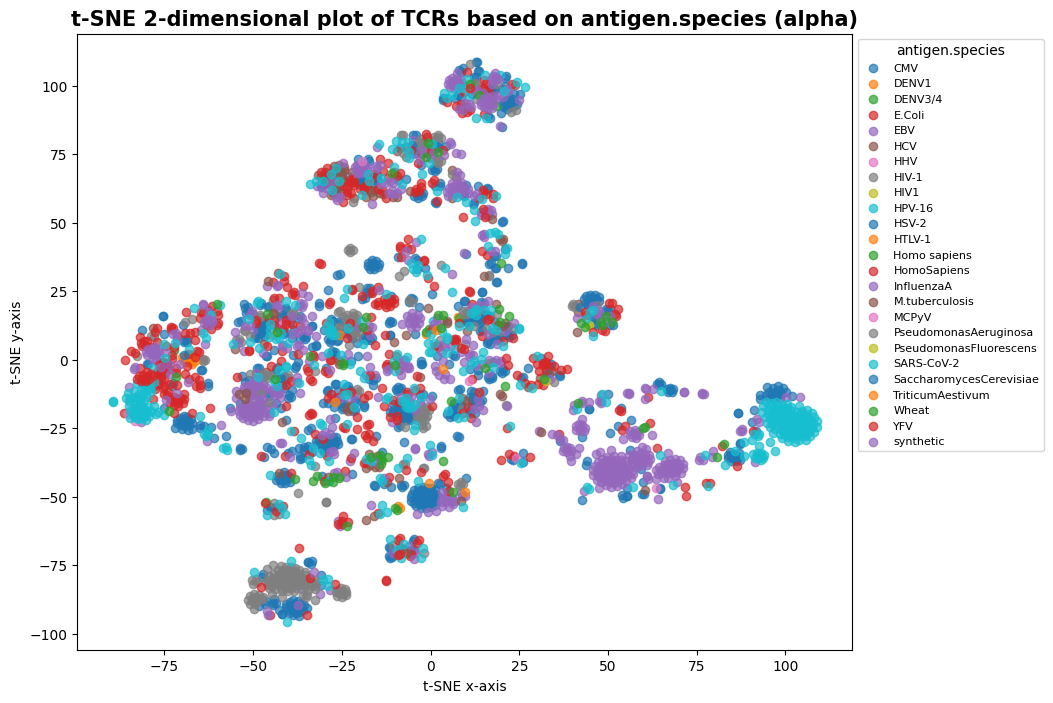

In [168]:
specificity = clone_df['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2"  # 根据 unique_antigen_species 的数量增减颜色
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(tsne_results[true_indiex, 0], tsne_results[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

### 使用Kmeans聚类

In [169]:
from sklearn.cluster import KMeans

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The defa

Text(0.5, 1.0, 'The elbow method showing the optimal k')

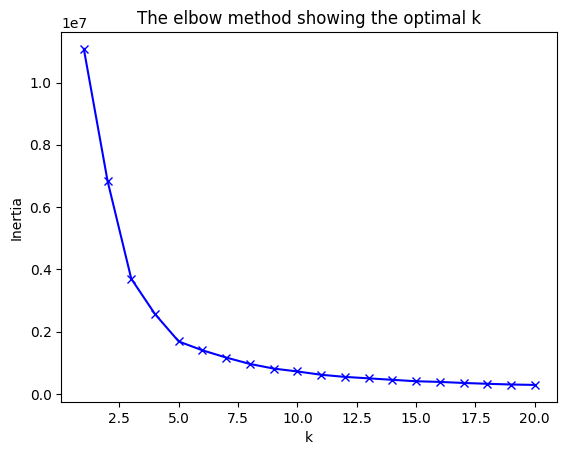

In [170]:
inertias = []
K = 20
for k in range(1, K+1):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsne_results) 
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, K+1), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The elbow method showing the optimal k')

In [171]:
k = 5
kmeans = KMeans(n_clusters=k)
kmeans.fit(tsne_results)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

C:\Users\54284\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


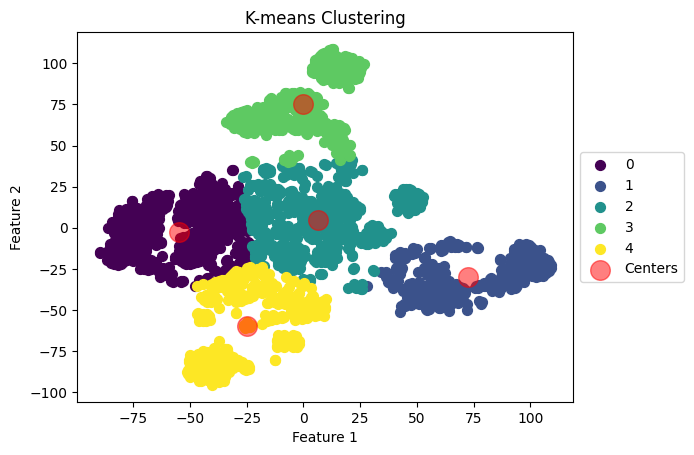

In [173]:
unique_labels = np.unique(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
label_color_map = dict(zip(unique_labels, colors))

for label, color in label_color_map.items():
    plt.scatter(tsne_results[labels == label, 0], tsne_results[labels == label, 1],
                c=[color], s=50, label=label)

# 画出聚类中心
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5, label='Centers')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# 显示图例，并将其放置在图形的右侧
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Analysis based on cluster results

In [301]:
tsne_results = np.column_stack((tsne_results, labels))

In [315]:
clone_df['label'] = labels

### cluster 0

In [316]:
label = 0
bool = np.isin(tsne_results[:, 2], label)

cluster_0_coordinate = tsne_results[bool][:, [0, 1]]

clone_df_0 = clone_df[clone_df['label'] == 0]

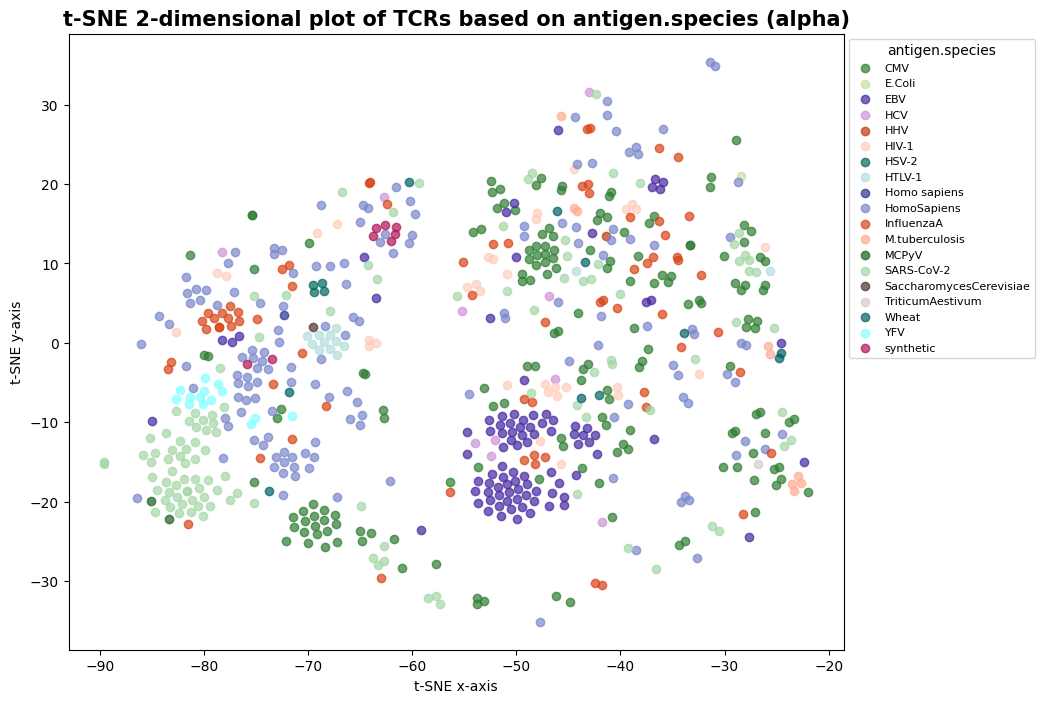

In [343]:
specificity = clone_df_0['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(cluster_0_coordinate[true_indiex, 0], cluster_0_coordinate[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

### cluster 1

In [318]:
label = 1
bool = np.isin(tsne_results[:, 2], label)

cluster_1_coordinate = tsne_results[bool][:, [0, 1]]

clone_df_1 = clone_df[clone_df['label'] == 1]

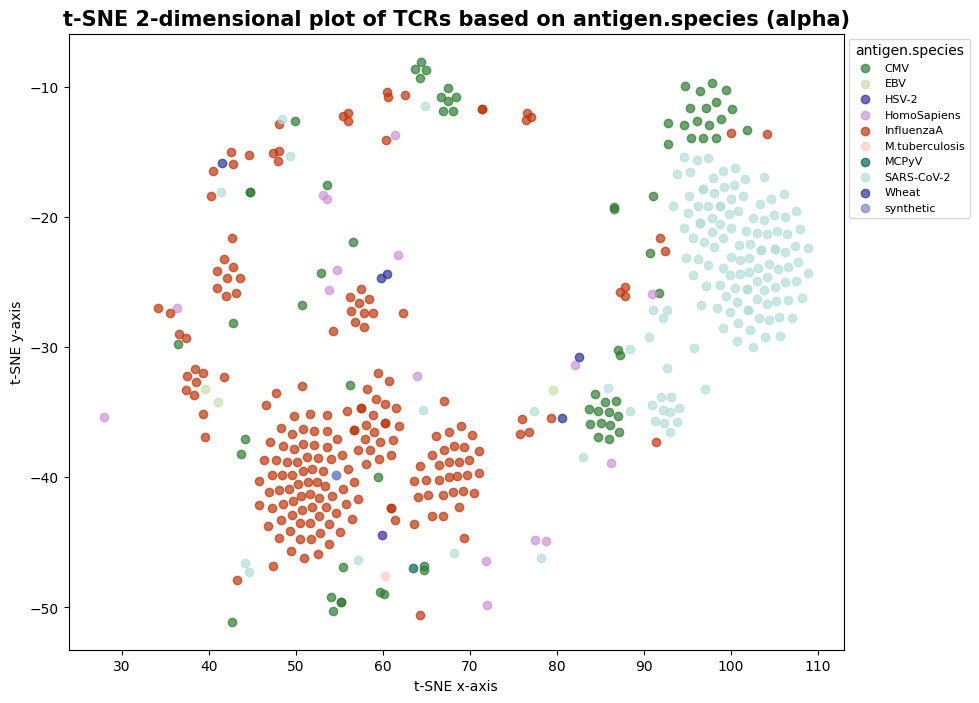

In [342]:
specificity = clone_df_1['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(cluster_1_coordinate[true_indiex, 0], cluster_1_coordinate[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

### cluster 2

In [322]:
label = 2
bool = np.isin(tsne_results[:, 2], label)

cluster_2_coordinate = tsne_results[bool][:, [0, 1]]

clone_df_2 = clone_df[clone_df['label'] == 2]

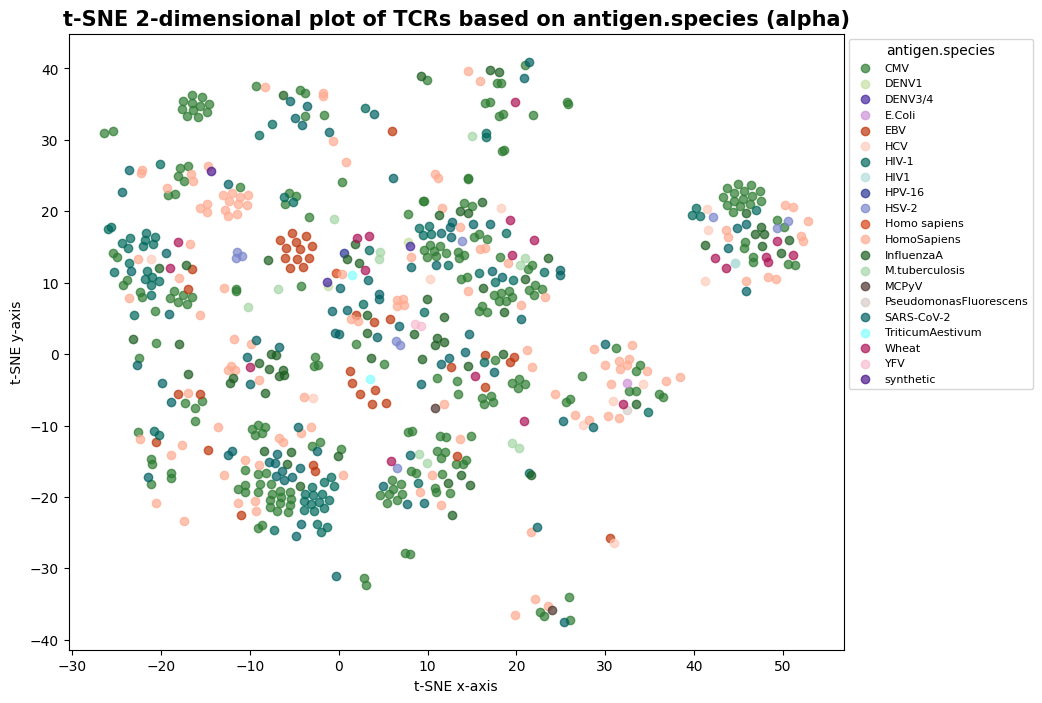

In [341]:
specificity = clone_df_2['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(cluster_2_coordinate[true_indiex, 0], cluster_2_coordinate[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

### cluster 3

In [324]:
label = 3
bool = np.isin(tsne_results[:, 2], label)

cluster_3_coordinate = tsne_results[bool][:, [0, 1]]

clone_df_3 = clone_df[clone_df['label'] == 3]

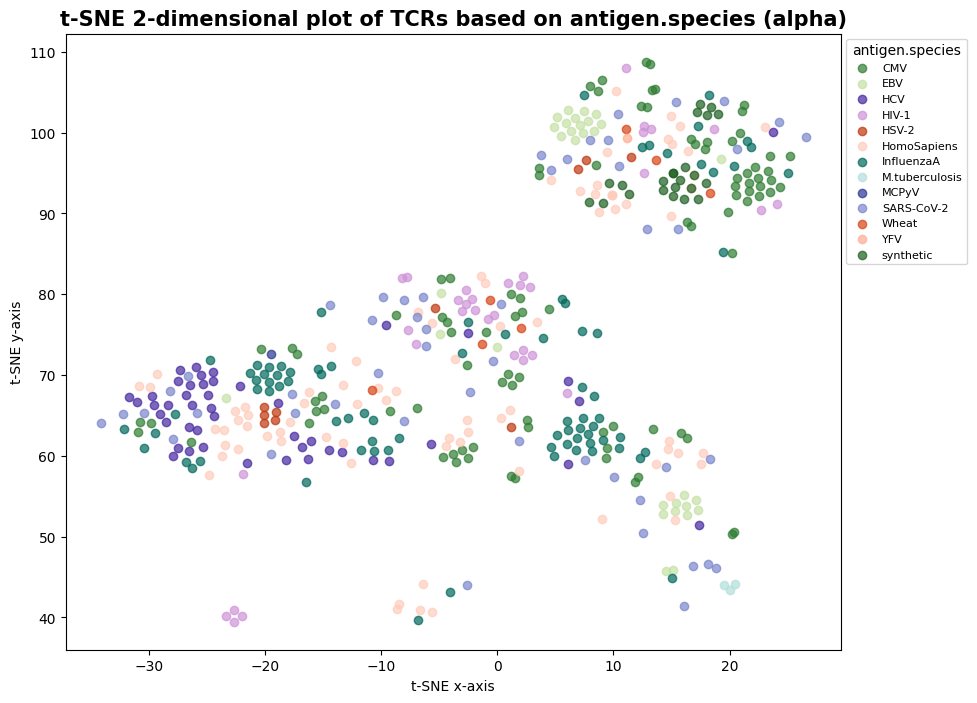

In [340]:
specificity = clone_df_3['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(cluster_3_coordinate[true_indiex, 0], cluster_3_coordinate[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

### cluster 4

In [326]:
label = 4
bool = np.isin(tsne_results[:, 2], label)

cluster_4_coordinate = tsne_results[bool][:, [0, 1]]

clone_df_4 = clone_df[clone_df['label'] == 4]

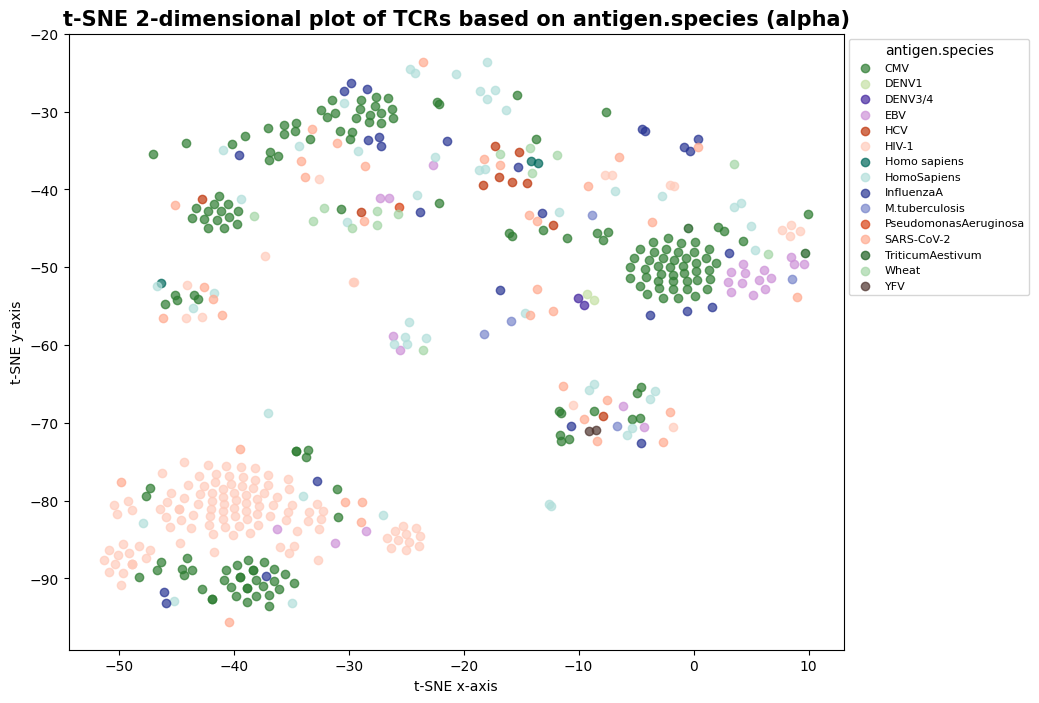

In [339]:
specificity = clone_df_4['antigen.species']
unique_antigen_species = np.unique(specificity)

# 定义一个颜色列表
color_list = [
    "#2E7D32", "#C5E1A5", "#4527A0", "#CE93D8", "#BF360C",
    "#FFCCBC", "#00695C", "#B2DFDB", "#283593", "#7986CB",
    "#D84315", "#FFAB91", "#1B5E20", "#A5D6A7", "#4E342E",
    "#D7CCC8", "#006064", "#84FFFF", "#AD1457", "#F8BBD0",
    "#4A148C", "#EA80FC", "#1A237E", "#8C9EFF", "#880E4F",
    "#FF80AB", "#37474F"
]
# 确保颜色列表的长度至少与 unique_antigen_species 的数量一致
colors = color_list[:len(unique_antigen_species)]

color_map = dict(zip(unique_antigen_species, colors))

plt.figure(figsize=(10, 8))

for antigen_species, color in color_map.items():
    true_indiex = (specificity == antigen_species)
    plt.scatter(cluster_4_coordinate[true_indiex, 0], cluster_4_coordinate[true_indiex, 1], color=color, label=antigen_species,
                    alpha=0.7)

plt.title('t-SNE 2-dimensional plot of TCRs based on antigen.species ({})'.format('alpha'), fontweight='bold', fontsize=15)
plt.xlabel('t-SNE x-axis')
plt.ylabel('t-SNE y-axis')
plt.legend(title='antigen.species', bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)
plt.savefig('alpha.png')
plt.show()

### 根据antigen epitope进行绘图

#### cluster 0 

In [348]:
clone_df_0

,complex.id,gene_a,cdr3_a_aa,v_a_gene,j_a_gene,species,mhc.a,mhc.b,mhc.class,antigen.epitope,...,web.method,web.method.seq,web.cdr3fix.nc,web.cdr3fix.unmp,cdr1_a_aa,cdr2_a_aa,pmhc_a_aa,count,clone_id,label
1,0,TRA,CAADYFQKLVF,TRAV13-1*01,TRAJ8*01,HomoSapiens,HLA-A*03,B2M,MHCI,QVPLRPMTYK,...,sort,amplicon,no,no,DSA......SNY,IRSN...VGE,NKTAKH,1,2,0
2,0,TRA,CAAFDDKIIF,TRAV12-2*01,TRAJ30*01,HomoSapiens,HLA-A*02,B2M,MHCI,LLWNGPMAV,...,sort,sanger,no,no,DRG......SQS,IYS....NGD,NKASQY,1,3,0
3,0,TRA,CAAGGGSYIPTF,TRAV12-2*01,TRAJ6*01,HomoSapiens,HLA-B*27:05,B2M,MHCI,KRWIILGLNK,...,sort,sanger,no,no,DRG......SQS,IYS....NGD,NKASQY,1,4,0
4,0,TRA,CAAGGGSYIPTF,TRAV12-2*01,TRAJ6*01,HomoSapiens,HLA-B*27:05,B2M,MHCI,KRWIIMGLNK,...,sort,sanger,no,no,DRG......SQS,IYS....NGD,NKASQY,1,5,0
5,0,TRA,CAAHPTGANSKLTF,TRAV13-1*01,TRAJ56*01,HomoSapiens,HLA-B*35:08,B2M,MHCI,HPVGEADYFEY,...,sort,sanger,no,no,DSA......SNY,IRSN...VGE,NKTAKH,1,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704,29620,TRA,CAARSGNTPLVF,TRAV29/DV5*01,TRAJ29*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,...,sort,singlecell,no,no,NSM......FDY,ISSI...KDK,NKSAKH,1,2705,0
2705,29621,TRA,CAVRHTNAGKSTF,TRAV21*01,TRAJ27*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,...,sort,singlecell,no,no,DSA......IYN,IQSS...QRE,DKSSGR,1,2706,0
2709,29625,TRA,CAVESYNTDKLIF,TRAV41*01,TRAJ34*01,HomoSapiens,HLA-A*24:01,B2M,MHCI,QYIKWPWYI,...,sort,singlecell,no,no,VGI.......SA,LSS.....GK,NIQEKH,1,2710,0
2717,30547,TRA,CAVEGGSNYKLTF,TRAV41*01,TRAJ53*01,HomoSapiens,HLA-DQA1*05:01,HLA-DQB1*02:01,MHCII,QLQPFPQPELPY,...,sort,singlecell,no,no,VGI.......SA,LSS.....GK,NIQEKH,1,2718,0
